In [5]:
pip install yfinance

  Using cached yfinance-0.2.52-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached lxml-5.3.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (3.8 kB)
  Using cached peewee-3.17.8.tar.gz (948 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
Using cached yfinance-0.2.52-py2.py3-none-any.whl (108 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached lxml-5.3.0-cp311-cp311-macosx_10_9_universal2.whl (8.1 MB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
Using cached so

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

def fetch_real_options_data(ticker, expiration_date):
    """
    Fetch options data for a specific ticker and expiration date from Yahoo Finance.
    """
    stock = yf.Ticker(ticker)

    # Get available expiration dates
    available_expirations = stock.options

    # Check if the provided expiration date is valid
    if expiration_date not in available_expirations:
        raise ValueError(
            f"Expiration `{expiration_date}` cannot be found. "
            f"Available expirations are: [{', '.join(available_expirations)}]"
        )

    options_chain = stock.option_chain(expiration_date)
    calls = options_chain.calls
    puts = options_chain.puts

    # Combine calls and puts
    calls['OptionType'] = 'Call'
    puts['OptionType'] = 'Put'
    options_data = pd.concat([calls, puts])

    # Add underlying price
    options_data['UnderlyingPrice'] = stock.history(period="1d")['Close'][-1]
    return options_data


def preprocess_data(options_data):
    """
    Preprocess options data to extract required features for training.
    """
    options_data['MidPrice'] = (options_data['bid'] + options_data['ask']) / 2
    # Convert 'lastTradeDate' to datetime with UTC timezone
    options_data['lastTradeDate'] = pd.to_datetime(options_data['lastTradeDate'], utc=True)
    # Get current time with UTC timezone
    now = pd.Timestamp.now(tz='UTC')
    options_data['DaysToExpiry'] = (options_data['lastTradeDate'] - now).dt.days
    options_data['DaysToExpiry'] = options_data['DaysToExpiry'] / 365.0  # Convert to fraction of a year
    options_data['PastPrices'] = options_data['UnderlyingPrice'].apply(lambda x: [x] * 10)  # Placeholder

    return options_data[['UnderlyingPrice', 'MidPrice', 'strike', 'DaysToExpiry', 'impliedVolatility', 'bid', 'ask', 'PastPrices']]
# Fetch and preprocess data
ticker = "AAPL"  # Example stock ticker

# Get available expiration dates for the ticker
stock = yf.Ticker(ticker)
available_expirations = stock.options

# Select the first available expiration date (or choose another one)
expiration_date = available_expirations[0]

# Now fetch and process the data with the valid expiration date
options_data = fetch_real_options_data(ticker, expiration_date)
processed_data = preprocess_data(options_data)


/var/folders/5r/zzkjd9_16y120pss7ty0rmgc0000gn/T/ipykernel_47990/1611269444.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  options_data['UnderlyingPrice'] = stock.history(period="1d")['Close'][-1]


In [7]:
def define_actions():
    return [0, 1, 2]  # Example: 0 for hold, 1 for buy call option, 2 for buy put option (expand as needed)


In [16]:
def calculate_transaction_costs(action):
    # Implement realistic transaction cost model based on action taken.
    transaction_cost_rate = 0.01 
    instrument_type, quantity = action  # Example rate; adjust as necessary.
    return abs(quantity) * transaction_cost_rate  # Simplified example.


def update_portfolio(portfolio, action, market_state):
    """
    Update the portfolio based on the selected action and current market state.

    Args:
        portfolio (Portfolio): The current portfolio object.
        action (tuple): The selected action, e.g., ("buy_call", 1).
        market_state (MarketState): The current market state.

    Returns:
        None: The portfolio is updated in place.
    """
    instrument_type, quantity = action  # Action is a tuple like ("buy_call", 1)
    transaction_cost_rate = calculate_transaction_costs(action)  # Example transaction cost rate

    # Determine the price of the instrument based on market state
    if instrument_type == "call":
        price = market_state.option_price
    elif instrument_type == "put":
        price = market_state.option_price
    elif instrument_type == "futures":
        price = market_state.current_price
    elif instrument_type == "forward":
        price = market_state.current_price
    else:
        price = 0  # For holding cash or invalid actions

    # Calculate transaction cost
    transaction_cost = abs(quantity) * price * transaction_cost_rate

    # Update portfolio positions
    if instrument_type in portfolio.positions:
        portfolio.positions[instrument_type] += quantity
    else:
        portfolio.positions[instrument_type] = quantity

    # Update cash balance
    portfolio.cash_balance -= quantity * price + transaction_cost

    # Ensure positions are valid (e.g., no short selling if restricted)
    if portfolio.positions[instrument_type] < 0:
        raise ValueError(f"Invalid position for {instrument_type}: {portfolio.positions[instrument_type]}")


In [11]:
pip install torch

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 12.6 MB/s eta 0:00:0000:0100:01
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
def define_actions():
    return [0, 1, 2]  # Example: 0 for hold, 1 for buy call option, 2 for buy put option (expand as needed)


In [20]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Environment Setup
class MarketState:
    def __init__(self, current_price, option_price, strike_price, expiry, implied_volatility, bid_ask_spread, past_prices):
        self.current_price = current_price
        self.option_price = option_price
        self.strike_price = strike_price
        self.expiry = expiry
        self.implied_volatility = implied_volatility
        self.bid_ask_spread = bid_ask_spread
        self.past_prices = past_prices

    def to_vector(self):
        return np.array([self.current_price, self.option_price, self.strike_price, self.expiry,
                         self.implied_volatility, self.bid_ask_spread] + self.past_prices)


def simulate_market_transition(current_state, action):
    # Implement logic to transition to the next market state based on the current state and action
    # stochastic model like Geometric Brownian Motion
    next_price = current_state.current_price * np.exp(np.random.normal(0, current_state.implied_volatility))
    return MarketState(
        current_price=next_price,
        option_price=current_state.option_price,  # Update as needed
        strike_price=current_state.strike_price,
        expiry=current_state.expiry,
        implied_volatility=current_state.implied_volatility,
        bid_ask_spread=current_state.bid_ask_spread,
        past_prices=current_state.past_prices[1:] + [next_price]  # Update past prices
        )


# Step 2: Portfolio and Instrument Representation
class Portfolio:
    def __init__(self):
        self.positions = {}
        self.cash_balance = 0

    def update_position(self, instrument, quantity):
        self.positions[instrument] = self.positions.get(instrument, 0) + quantity

# Step 3: Reward Calculation
def calculate_pnl_change(portfolio, market_state, discount_factor):
    pnl_change = 0
    for instrument, quantity in portfolio.positions.items():
        payoff = max(0, market_state.current_price - market_state.strike_price if instrument == "call" else market_state.strike_price - market_state.current_price)
        pnl_change += quantity * payoff
    return discount_factor * pnl_change

def calculate_reward(portfolio, pnl_change, trading_costs):
    return pnl_change - trading_costs

# Step 4: Hedging Actions and Constraints
class ActionConstraints:
    def __init__(self, position_limits, short_sell_restrictions):
        self.position_limits = position_limits
        self.short_sell_restrictions = short_sell_restrictions

    def is_action_valid(self, action, portfolio):
         # Placeholder for constraints validation

         return True


def bellman_equation(value_function, current_state, portfolio, actions, discount_factor):
    future_values = []

    for action in actions:
        # Simulate the next market state after taking an action
        next_state = simulate_market_transition(current_state, action)

        # Calculate future value using the value function
        future_value = value_function(next_state.to_vector()).item()

        # Calculate reward using risk-adjusted return
        pnl_change = calculate_pnl_change(portfolio, next_state, discount_factor)
        reward = calculate_risk_adjusted_reward(portfolio, pnl_change, trading_costs=0.01)

        # Adjusted value calculation according to Bellman's equation
        adjusted_value = discount_factor * future_value + reward

        future_values.append(adjusted_value)

    return max(future_values)  # Return the maximum adjusted future value


# Step 5: Value Function and Bellman Equation
class ValueFunction(nn.Module):
    def __init__(self, input_size):
        super(ValueFunction, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),  # Input size to 128
            nn.ReLU(),
            nn.Linear(128, 64),  # 128 to 64
            nn.ReLU(),
            nn.Linear(64, 1)    # 64 to 1 (output)
        )

    def forward(self, state_vector):
        return self.fc(torch.tensor(state_vector, dtype=torch.float32))

# Step 6: Policy Definition and Execution
class Policy(nn.Module):
    def __init__(self, state_size, action_size):
        super(Policy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, state_vector):
        return torch.softmax(self.fc(torch.tensor(state_vector, dtype=torch.float32)), dim=-1)

def calculate_risk_adjusted_reward(portfolio, pnl_change, trading_costs):
    # Example of a risk-adjusted reward calculation
    risk_aversion_coefficient = 0.5  # Adjust this value based on risk preferences
    adjusted_reward = pnl_change - trading_costs - risk_aversion_coefficient * np.std(pnl_change)
    return adjusted_reward


# Step 7: Training and Testing with Real Data
def generate_market_data_from_real_data(processed_data):
    """
    Generate MarketState instances using processed real options data.
    """
    market_data = []
    for _, row in processed_data.iterrows():
        market_state = MarketState(
            current_price=row['UnderlyingPrice'],
            option_price=row['MidPrice'],  # Assuming 'MidPrice' is the option price
            strike_price=row['strike'],
            expiry=row['DaysToExpiry'],
            implied_volatility=row['impliedVolatility'],
            bid_ask_spread=row['ask'] - row['bid'],
            past_prices=row['PastPrices']
        )  # Removed sentiment_data here
        market_data.append(market_state)
    return market_data

market_data = generate_market_data_from_real_data(processed_data)


portfolio = Portfolio()
value_function = ValueFunction(input_size=16)
policy = Policy(state_size=16, action_size=3)
optimizer = optim.Adam(list(value_function.parameters()) + list(policy.parameters()), lr=0.001)

rewards_per_epoch = []
portfolio_values = []

def train_model(market_data, portfolio, value_function, policy, epochs=100):
    actions = define_actions()  # Define possible actions like buy/sell options or futures

    for epoch in range(epochs):
        total_reward = 0

        for market_state in market_data:
            state_vector = market_state.to_vector()
            action_probs = policy(state_vector)  # Get action probabilities from the policy network
            epsilon = 1e-6  # A small positive value
            action_probs = action_probs + epsilon
            
            action_probs = torch.clamp(action_probs,  0.0, 1.0)  
            action_probs = action_probs / action_probs.sum() 
            # Sample an action based on probabilities
            action_index = torch.multinomial(action_probs, 1).item()
            if action_index == 0:
                selected_action = ("hold", 0)  # Hold action, quantity 0
            elif action_index == 1:
                selected_action = ("call", 1)  # Buy call, quantity 1
            elif action_index == 2:
                selected_action = ("put", 1)   # Buy put, quantity 1

            # Update portfolio based on selected action
            update_portfolio(portfolio, selected_action, market_state)

            # Use Bellman equation to compute expected future value and rewards
            future_value_estimate = bellman_equation(value_function, market_state, portfolio, actions, discount_factor=0.99)

            # Calculate P&L change and reward
            pnl_change = calculate_pnl_change(portfolio, market_state, discount_factor=0.99)
            reward = calculate_risk_adjusted_reward(portfolio, pnl_change, trading_costs=0.01)

            optimizer.zero_grad()
            # Loss calculation using both immediate reward and future value estimate
            loss = -torch.tensor(reward + future_value_estimate, requires_grad=True)  # Negative because we minimize loss, convert to tensor
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(value_function.parameters(), max_norm=1.0)
            optimizer.step()

            total_reward += reward

        rewards_per_epoch.append(total_reward)

        # Calculate and store portfolio value for this epoch (example)
        portfolio_value = portfolio.cash_balance  # Start with cash balance
        for instrument, quantity in portfolio.positions.items():
            # Example: Assume 'market_state.current_price' represents the current price of the instrument
            if instrument in ["call", "put"]:  # Assuming these are tracked in positions
                portfolio_value += quantity * market_state.option_price  # Update with option prices
            elif instrument == "futures":
                portfolio_value += quantity * market_state.current_price  # Update with futures prices

        portfolio_values.append(portfolio_value)  # Append to the list

        print(f"Epoch {epoch + 1}/{epochs}, Total Reward: {total_reward}, Portfolio Value: {portfolio_value}")

# Example usage:
train_model(market_data, portfolio, value_function, policy)

# train_model(market_data, portfolio, value_function, policy)

# Step 8: Numerical Stability
# Included in optimizer (Adam). Additional checks for gradient clipping or regularization can be added if needed.


#calculate and print the sharpe ratio and max drawdown
sharpe_ratio = np.mean(rewards_per_epoch) / np.std(rewards_per_epoch)
print(f"Sharpe Ratio: {sharpe_ratio}")
max_drawdown = max(portfolio_values) - min(portfolio_values)
print(f"Maximum Drawdown: {max_drawdown}")


# Step 9: Visualization and Analysis

plt.subplot(1, 2, 1)
plt.plot(rewards_per_epoch, label="Total Rewards", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.title("Rewards Over Epochs")
plt.legend()

# Plot portfolio value
plt.subplot(1, 2, 2)
plt.plot(portfolio_values, label="Portfolio Value", color="green")
plt.xlabel("Epoch")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

Epoch 1/300, Random Portfolio Value: 25210672.81534972
Epoch 2/300, Random Portfolio Value: 25198668.88605421
Epoch 3/300, Random Portfolio Value: 25209477.944868147
Epoch 4/300, Random Portfolio Value: 25198955.055255428
Epoch 5/300, Random Portfolio Value: 25209514.67378355
Epoch 6/300, Random Portfolio Value: 25238482.968146205
Epoch 7/300, Random Portfolio Value: 25229907.09208877
Epoch 8/300, Random Portfolio Value: 25241182.144050755
Epoch 9/300, Random Portfolio Value: 25260623.786075577
Epoch 10/300, Random Portfolio Value: 25249615.935621172
Epoch 11/300, Random Portfolio Value: 25266540.60113845
Epoch 12/300, Random Portfolio Value: 25274778.58992096
Epoch 13/300, Random Portfolio Value: 25288596.912591703
Epoch 14/300, Random Portfolio Value: 25274118.834349368
Epoch 15/300, Random Portfolio Value: 25279407.513793483
Epoch 16/300, Random Portfolio Value: 25270749.151291344
Epoch 17/300, Random Portfolio Value: 25256211.137806077
Epoch 18/300, Random Portfolio Value: 25245295

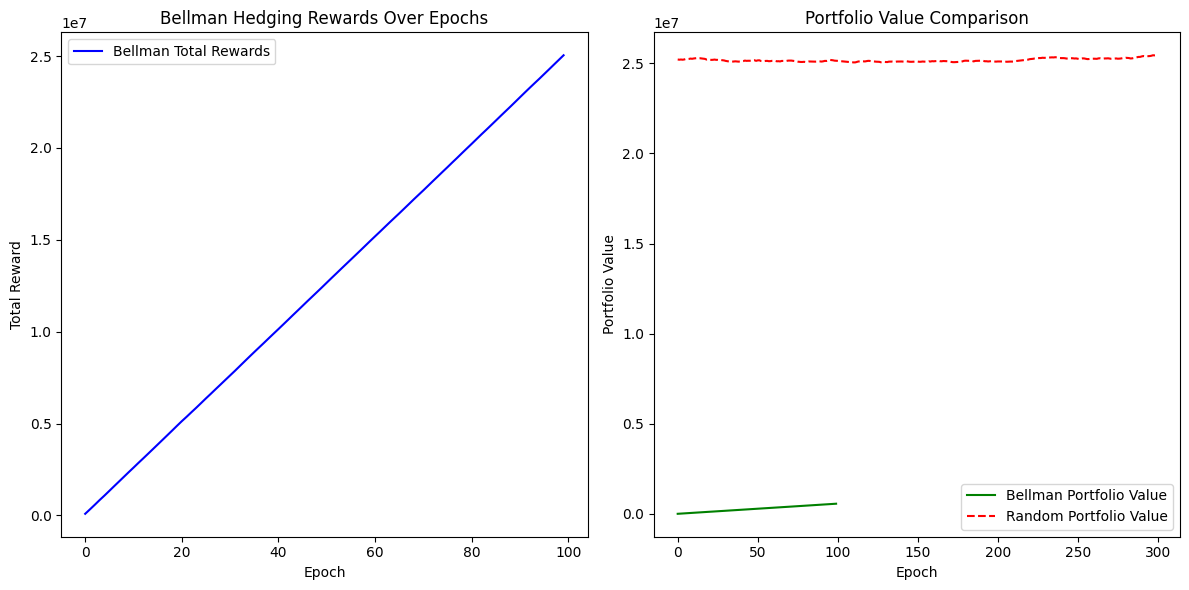

In [17]:
def random_investment_strategy(market_data, portfolio, epochs=300):
    random_portfolio_values = []
    for epoch in range(epochs):
        random_portfolio_value = 0

        for market_state in market_data:
            # Choose random actions (-1 for sell, 0 for hold, 1 for buy)
            random_action = np.random.choice([-1, 0, 1])

            # Update portfolio based on random action
            if random_action == -1:  # Sell
                portfolio.update_position("instrument", quantity=-1)
            elif random_action == 1:  # Buy
                portfolio.update_position("instrument", quantity=1)

            # Calculate PnL change
            pnl_change = calculate_pnl_change(portfolio, market_state, discount_factor=0.99)
            random_portfolio_value += pnl_change

        random_portfolio_values.append(random_portfolio_value)
        print(f"Epoch {epoch + 1}/{epochs}, Random Portfolio Value: {random_portfolio_value}")

    return random_portfolio_values
random_portfolio_values = random_investment_strategy(market_data, portfolio)
# Visualization and Comparison
plt.figure(figsize=(12, 6))

# Plot rewards and portfolio values for Bellman Hedging
plt.subplot(1, 2, 1)
plt.plot(rewards_per_epoch, label="Bellman Total Rewards", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.title("Bellman Hedging Rewards Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(portfolio_values, label="Bellman Portfolio Value", color="green")
plt.plot(random_portfolio_values, label="Random Portfolio Value", color="red", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Comparison")
plt.legend()

plt.tight_layout()
plt.show()


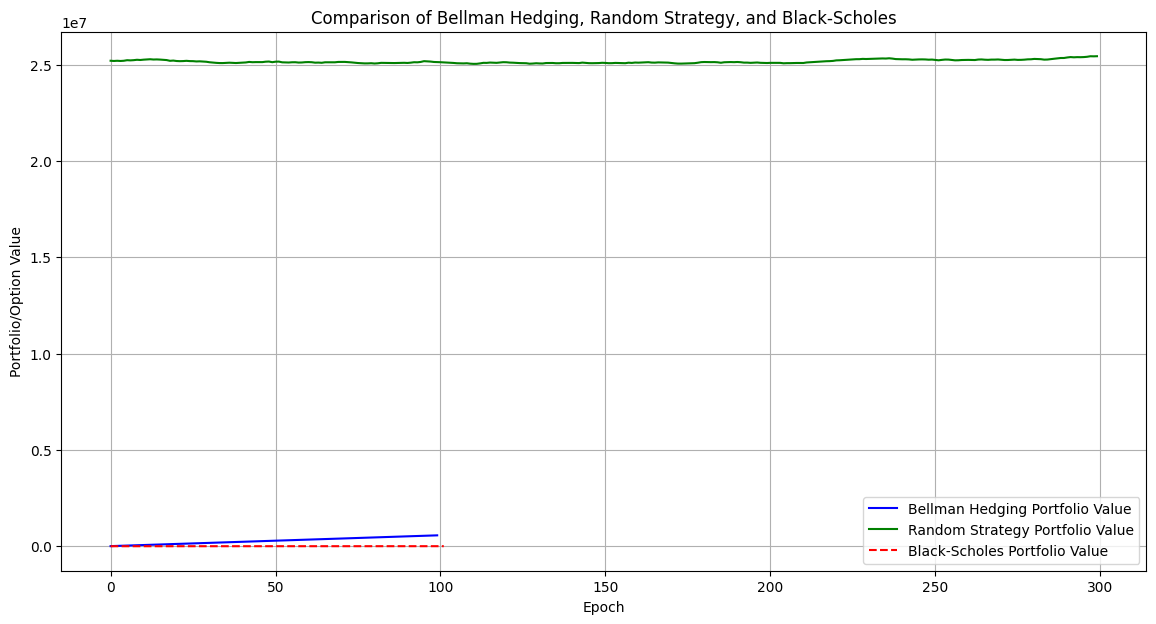

In [18]:
from scipy.stats import norm
import math

# Black-Scholes Formula for Call Option
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    call_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    return call_price

# Generate Black-Scholes prices
import numpy as np

# Define synthetic parameters
def generate_synthetic_parameters(market_data):
    strike_prices = [state.current_price * np.random.uniform(0.9, 1.1) for state in market_data]
    risk_free_rate = 0.01  # 1% annualized risk-free rate
    volatilities = [0.2] * len(market_data)  # Constant volatility of 20% (can vary)
    return strike_prices, risk_free_rate, volatilities

# Generate parameters
strike_prices, risk_free_rate, volatilities = generate_synthetic_parameters(market_data)

# Adjust Black-Scholes calculation with generated parameters
def calculate_bs_portfolio_values(market_data, strike_prices, risk_free_rate, volatilities):
    portfolio_values = []
    portfolio_value = 0

    for i, state in enumerate(market_data):
        # Calculate Black-Scholes price using synthetic parameters
        time_to_maturity = 1.0  # Example: 1 year to expiry
        bs_price = black_scholes_call_price(
            S=state.current_price,
            K=strike_prices[i],
            T=time_to_maturity,
            r=risk_free_rate,
            sigma=volatilities[i]
        )

        # Update portfolio value
        portfolio_value += bs_price
        portfolio_values.append(portfolio_value)

    return portfolio_values

# Calculate BS portfolio values
bs_portfolio_values = calculate_bs_portfolio_values(market_data, strike_prices, risk_free_rate, volatilities)


# Visualization of all methods
plt.figure(figsize=(14, 7))

# Bellman Hedging results
plt.plot(portfolio_values, label="Bellman Hedging Portfolio Value", color="blue")

# Random strategy results
plt.plot(random_portfolio_values, label="Random Strategy Portfolio Value", color="green")

# Black-Scholes results
plt.plot(bs_portfolio_values, label="Black-Scholes Portfolio Value", color="red", linestyle="dashed")

# Plot settings
plt.xlabel("Epoch")
plt.ylabel("Portfolio/Option Value")
plt.title("Comparison of Bellman Hedging, Random Strategy, and Black-Scholes")
plt.legend()
plt.grid(True)
plt.show()
